# Run multi threaded clustering and write to file

In [1]:
#add the dev version of aare
import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import time

#Directly import what we need from aare
from aare import File, ClusterFileSink, ClusterFinderMT, ClusterFile, hitmap
from aare._aare import calculate_eta2


base = Path('/mnt/sls_det_storage/highZ_data/Erik/CZT_Mo')
out_fname = base/'processed/Mo.clust'
pedestal_file = base/'20241212_CZTsolo_Pedestal_Tp_15C_tint_100_period_0910us_master_0.json'
data_file = base/'20241212_CZTsolo_Xray_Tp_15C_tint_100_period_0910us_master_0.json'

Example run on: **2025-01-14 11:44** with aare: **dev**

## Pedestal

In [2]:
n_frames_pd = 1000
cluster_size = (3,3)
image_size = (256,256) #could also be read from master file


cf = ClusterFinderMT(image_size, cluster_size, n_sigma = 10, capacity = 2000, n_threads=48)

t0 = time.perf_counter()

with File(pedestal_file) as f:
    for i in range(n_frames_pd):
        img = f.read_frame()
        cf.push_pedestal_frame(img)
cf.sync() #Wait until the input queue is empty, purely for timing

elapsed_t = time.perf_counter()-t0
print(f'Pedestal took: {elapsed_t:.3f}s')



Pedestal took: 0.967s


### Pedestal before clustering

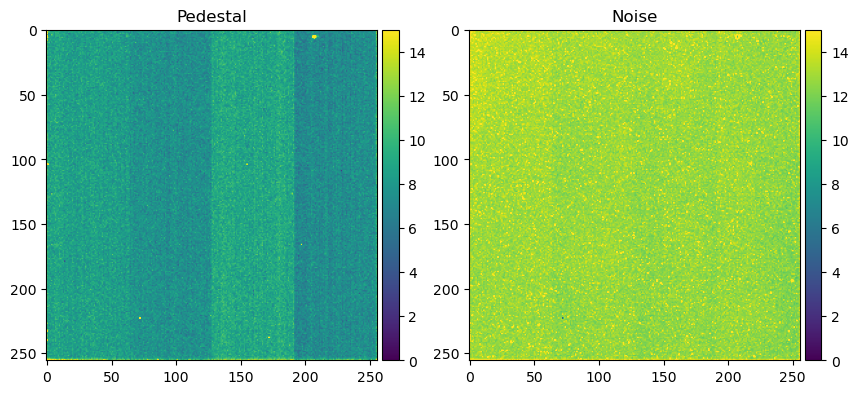

In [3]:
#Stop the MT cluster finder to read back pedestal and nosie from thread 19
cf.stop()
pd = cf.pedestal(19)
noise = cf.noise(19)
cf.start()

fig, axs = plt.subplots(1,2, figsize = (10,5))
im = axs[0].imshow(pd)
im.set_clim(4000,6000)
axs[0].set_title('Pedestal')


im = axs[1].imshow(noise)
im.set_clim(0,15)
axs[1].set_title('Noise')

#Make sure the color bar has the same height as the image
for ax in axs:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

# Clustering

In [4]:
N = 50000
t_start = time.perf_counter()
t0 = time.perf_counter()

#Connect a sink to the ClusterFinder, this will pull all clustered frames
#from the ClusterFinder and write them to a old style cluster file
sink = ClusterFileSink(cf, out_fname)

with File(data_file) as f:
    f.seek(500) #skip the first 500 frames to avoid temperature issues
    for i in range(N):
        frame_number = f.frame_number()
        frame = f.read_frame()
        cf.find_clusters(frame, frame_number)

#once we are done with the processing we stop the ClusterFinderMT and the ClusterFileSink
#This would also be needed if we want to access data that is used by the processing threads
cf.stop()
sink.stop()

t_elapsed = time.perf_counter()-t0
print(f'Clustering (and writing to disk) {N} frames took {t_elapsed:.2f}s  {N/t_elapsed:.0f} FPS')


Clustering (and writing to disk) 50000 frames took 3.02s  16578 FPS


## Plot the results

- Load data from the cluster file
- Iterate over the file
- Fill the histogram with the sum of the cluster

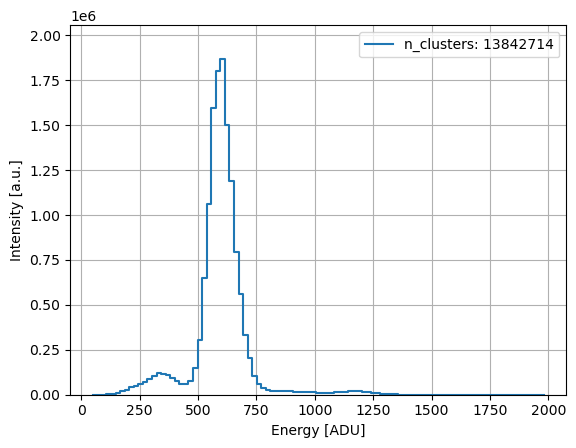

In [5]:
#one histogram with the sum for each cluster in the file
hist1 = bh.Histogram(bh.axis.Regular(100, 50, 2000))

with ClusterFile(out_fname) as f:
    for clusters in f:
        hist1.fill(clusters.sum())
        

fig, ax = plt.subplots()
ax.step(hist1.axes[0].edges[:-1], hist1.values(), where="post", label = f'n_clusters: {hist1.sum():.0f}');
ax.set_xlabel('Energy [ADU]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend()
ax.set_ylim(0, hist1.values().max()*1.1)
ax.grid()

### Make an hitmap from all clusters

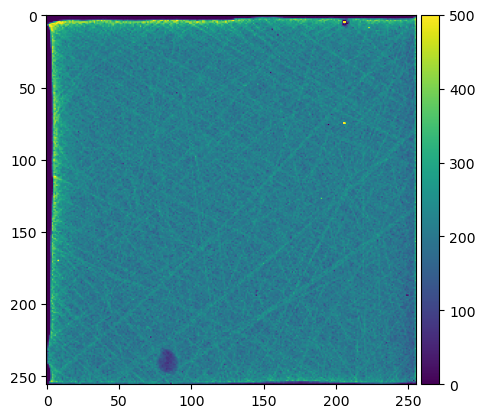

In [6]:
img = np.zeros((256,256))
with ClusterFile(out_fname) as f:
    for clusters in f:
        img += hitmap(img.shape, clusters)
        
fig, ax = plt.subplots()
im = ax.imshow(img)
im.set_clim(0,500)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

### Make a 3D histogram for calibration

In [7]:
t0 = time.perf_counter()
offset= -0.5
hist3d = bh.Histogram(
    bh.axis.Regular(256, 0+offset, 256+offset),  #x
    bh.axis.Regular(256, 0+offset, 256+offset),  #y
    bh.axis.Regular(200, 0, 2000), #ADU
)

total_clusters = 0
with ClusterFile(out_fname, chunk_size = 1000) as f:
    for i, clusters in enumerate(f):
        arr = np.array(clusters)
        total_clusters += clusters.size
        hist3d.fill(arr['x'], arr['y'], clusters.sum())

        
t_elapsed = time.perf_counter()-t0
print(f'Histogram filling took: {t_elapsed:.3f}s {total_clusters/t_elapsed/1e6:.3f}M clusters/s')

Histogram filling took: 0.938s 14.816M clusters/s


**Plot the 2D projection of all clusters (identical to hitmap)**

(256, 256)


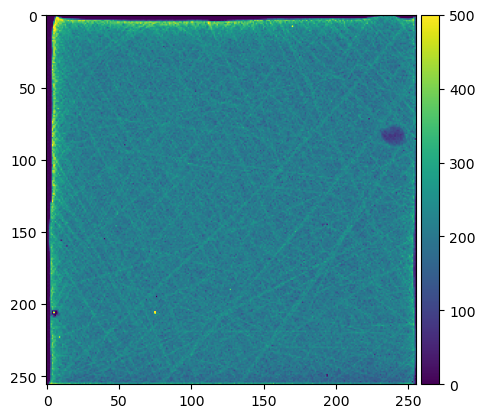

In [8]:
#Project the histogram, showing number of clusters per pixel
img = hist3d.values().sum(axis = 2)
fig, ax = plt.subplots()
im = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
im.set_clim(0,500)
print(img.shape)

**Plot the histogram from one pixel (this is later used for fitting)**

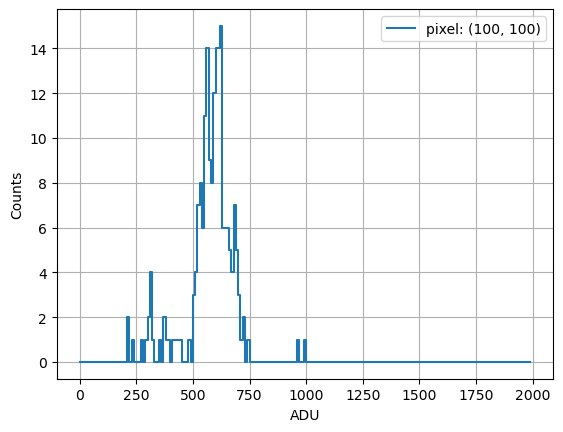

In [9]:
pixel = (100,100)
counts = hist3d.values()[*pixel]

fig, ax = plt.subplots()
ax.step(hist3d.axes[2].edges[:-1], counts, where="post", label = f'pixel: {pixel}');
ax.set_xlabel('ADU')
ax.set_ylabel('Counts')
ax.legend()
ax.grid()

### Clusters per frame

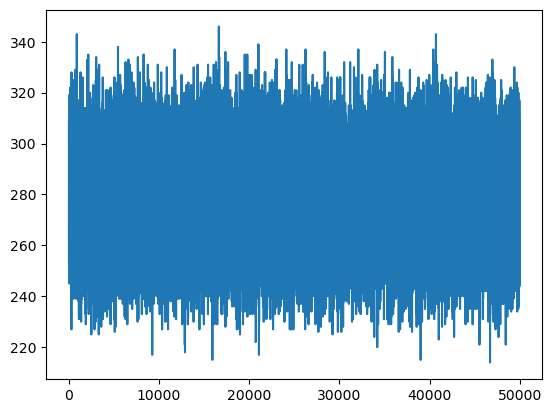

In [10]:
clusters_per_frame = np.zeros(N)
frame_numbers = np.zeros(N)
img = np.zeros((256,256))
with ClusterFile(out_fname) as f:
    for i in range(N):
        clusters = f.read_frame()
        clusters_per_frame[i] = clusters.size
        frame_numbers[i] = clusters.frame_number
        

fig, ax = plt.subplots()
ax.plot(clusters_per_frame[frame_numbers.argsort()])

### Noise and pedestal after clustering

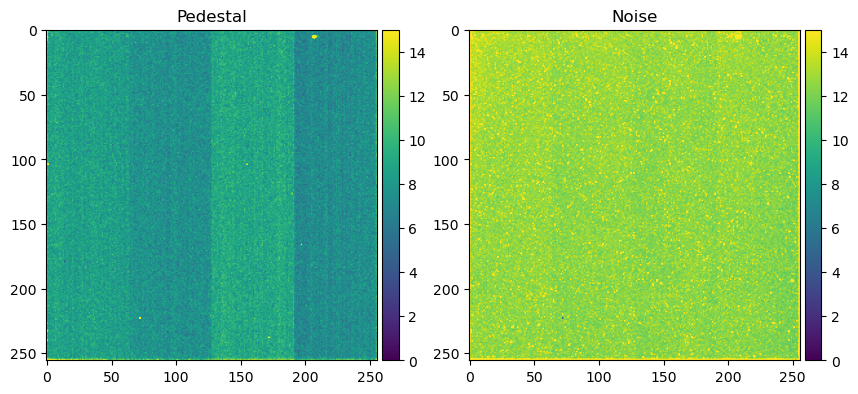

In [11]:
fig, axs = plt.subplots(1,2, figsize = (10,5))

pd = cf.pedestal(7)
noise = cf.noise(7)

im = axs[0].imshow(pd)
im.set_clim(4000,6000)
axs[0].set_title('Pedestal')


im = axs[1].imshow(noise)
im.set_clim(0,15)
axs[1].set_title('Noise')

for ax in axs:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

In [12]:
#2D histogram to show eta2
hist = bh.Histogram(bh.axis.Regular(50, 0, 1), bh.axis.Regular(50, 0, 1))

t0 = time.perf_counter()
total_clusters = 0
with ClusterFile(out_fname) as f:
    for clusters in f:
        eta2 = calculate_eta2(clusters)
        hist.fill(eta2[:,0], eta2[:,1])
        total_clusters += clusters.size
elapsed_t = time.perf_counter()-t0
print(f'Calcualting eta2 took: {elapsed_t:.3f}s, {total_clusters/elapsed_t:.3g} clusters/s')


Calcualting eta2 took: 0.537s, 2.59e+07 clusters/s


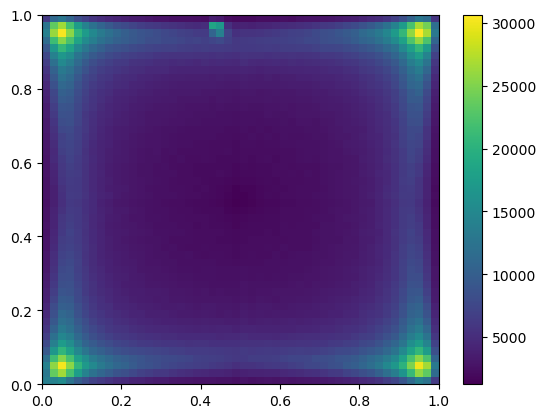

In [13]:
fig, ax = plt.subplots()
mesh = ax.pcolormesh(*hist.axes.edges.T, hist.view())
fig.colorbar(mesh)